In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

In [2]:
def generate_world_points(length, width, height, num_points):

    # Define the bounds for random points generation
    x_min = -length/2
    x_max = length/2
    y_min = -width/2
    y_max = width/2
    z_min = -height/2
    z_max = height/2

    # Generate random points
    x_rand = np.random.uniform(x_min, x_max, num_points-8)
    y_rand = np.random.uniform(y_min, y_max, num_points-8)
    z_rand = np.random.uniform(z_min, z_max, num_points-8)

    # Combine the random points into a single array
    points_rand = np.stack(
        (x_rand, y_rand, z_rand, np.ones((num_points-8))), axis=1)

    # Generate boundary points
    x_bound = np.array([x_min, x_max, x_min, x_max,
                       x_min, x_max, x_min, x_max])
    y_bound = np.array([y_min, y_min, y_max, y_max,
                       y_min, y_min, y_max, y_max])
    z_bound = np.array([z_min, z_min, z_min, z_min,
                       z_max, z_max, z_max, z_max])

    # Combine the boundary points into a single array
    points_bound = np.stack((x_bound, y_bound, z_bound, np.ones((8))), axis=1)

    # Combine all the points
    world_points = np.concatenate((points_rand, points_bound), axis=0)
    
    return world_points.T


In [3]:
def convert_to_radians(theeta_x, theeta_y, theeta_z):
    #Convert the angle to theetha
    theeta_x = theeta_x * np.pi/180
    theeta_y = theeta_y * np.pi/180
    theeta_z = theeta_z * np.pi/180

    return theeta_x, theeta_y, theeta_z


Projection Matrix :  $P_{mat}= M_{int} * M_{ext}$

So we have : 

1. Intrinsic Paramters:

$M_{int}=
\left[\begin{matrix}
fk_x & S & C_x & 0\\
0 & fk_y & C_y & 0\\
0 & 0 & 1 & 0
\end{matrix}\right]$

2. Extrinsic Paramters:
$M_{ext}=
\left[\begin{matrix}
R & T\\
0 & 1
\end{matrix}\right]$


$ T=
\left[\begin{matrix}
x \\
y \\
z \\
1
\end{matrix}\right]$

We multiply these rotations to have the total rotation of the system: 

$R_t = R_z * R_y * R_z $

with $\beta$ is the angle of rotation around _'x'_, $\alpha$ around _'y'_ and $\theta$ around _'z'_ 

$R_{z}=
\left[\begin{matrix}
cos(\theta) & -sin(\theta) & 0\\
sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 1 
\end{matrix}\right]$


$R_{y}=
\left[\begin{matrix}
cos(\alpha) & 0 & sin(\alpha)\\
 0 & 1 & 0\\
-sin(\alpha) & 0 & cos(\alpha) 
\end{matrix}\right]$


$R_{x}=
\left[\begin{matrix}
1 & 0 & 0\\
0 & cos(\beta) & -sin(\beta)\\
0 & sin(\beta) & cos(\beta) 
\end{matrix}\right]$

In [4]:
def calculate_rotation_matrix(theeta_x, theeta_y, theeta_z):
    theeta_x, theeta_y, theeta_z = convert_to_radians(theeta_x, theeta_y, theeta_z)

    # Rotation Matrix for 'x' orientation
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theeta_x), -np.sin(theeta_x)],
        [0, np.sin(theeta_x), np.cos(theeta_x)],
        [0, 0, 0]])

    # Rotation Matrix for 'y' orientation
    Ry = np.array([
        [np.cos(theeta_y), 0, np.sin(theeta_y)],
        [0, 1, 0],
        [-np.sin(theeta_y), 0, np.cos(theeta_y)],
        [0, 0, 0]])

    # Rotation Matrix for 'z' orientation
    Rz = np.matrix([
        [np.cos(theeta_z), -np.sin(theeta_z), 0],
        [np.sin(theeta_z), np.cos(theeta_z), 0],
        [0, 0, 1],
        [0, 0, 0]])

    # Calculate the final rotation matrix R by multiplying Rz, Ry.T and Rx
    R = np.dot(Rz, Ry.T)
    R = np.dot(R, Rx)
    return R


In [5]:
def translation_matrix(tx, ty, tz):
    # Make the Rotation Matrix
    t = np.array([[tx],
                  [ty],
                  [tz],
                  [1]])
    return t


In [6]:
def intrinsics(fx, fy, cx, cy, s):
    # Define the camera intrinsic matrix
    K = np.array([[fx, 0, 0, 0],
                  [0, fy, 0, 0],
                  [0,  0, 1, 0]])

    I = np.array([[1, s, cx],
                  [0, 1, cy],
                  [0,  0, 1]])
    
    return I, K

# Camera Simulation

Now that we have the Extrinsic and Intrinsic Matrixes, we can now simulate a camera.
To simulate a pinhole camera, the mathematical model is:
$P_{image} = M_{intrinsics} * M_{Extrinsics} * P_{world}$

In [7]:
def camera_simulation(X_world, fx, fy, cx, cy, s, R, t):

    # Concatenate the rotation matrix and translation vector to get the extrinsic parameters matrix "Rt"
    Rt = np.hstack((R, t))

    I, K  = intrinsics(fx, fy, cx, cy, s)


    print('The projection Matrix is: \n', I @ K @ Rt)

    # Project the 3D object points onto the image plane
    x_image_hom = I @ K @ Rt @ X_world # perspective projection

    # print("In Homogeneous coordinates, picture point are: \n", x_image_hom.T)

    # normalize by the homogeneous coordinate 
    x_image_hom = np.true_divide(x_image_hom, x_image_hom[-1])
    x_image_hom = np.array(x_image_hom, dtype=float)

    # print("In Norm Homogeneous coordinates, picture point are: \n", x_image_hom.T)

    x_image = x_image_hom[:-1]
    x_image = np.array(x_image, dtype=float)
    
    # print("In Eculedian coordinates, picture point are: \n", x_image.T)
    # print("In Eculedian coordinates, World point are: \n", X_world[:-1].T)

    return x_image, X_world


# Camera Calibration using DLT method:

By using the DLT, we can estimate the Callibration matrix ($P_{3X4}$).

## Sources:
[**Prof. Dr. Cyrill Stachniss**](https://www.ipb.uni-bonn.de/people/cyrill-stachniss/)<br><br>
[**Direct Linear Transform** -DLT- for Camera Calibration and Localization Slides by Prof. Dr. Cyrill Stachniss](https://www.ipb.uni-bonn.de/html/teaching/photo12-2021/2021-pho1-21-DLT.pptx.pdf)  <br><br>
[Youtube Video of DLT by Prof. Dr. Cyrill Stachniss](https://www.youtube.com/watch?v=3NcQbZu6xt8&t=1s&ab_channel=CyrillStachniss)<br><br>

In [8]:
def camera_calibration_dlt(world_points, image_points):
    """
    Calibrate camera using DLT method
    :param world_points: 3D world points (nx3)
    :param image_points: 2D image points (nx2)
    :return: calibration matrix (3x4)
    :NOTE: Some help was taken from the Notes of (Prof. Dr. Cyrill Stachniss) for the execution of this.
    """
    # Get number of points
    n = world_points.shape[0]
    A = np.zeros((2*n, 12))

    # Iterate through the points
    for i in range(n):
        # Get world point
        X, Y, Z = world_points[i,:]
        # Get image point
        x, y = image_points[i,:]
        # Construct the first & second row of matrix A
        A[2*i, :] = [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x]
        A[2*i+1, :] = [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]

    # Perform singular value decomposition on A
    U, S, VT = np.linalg.svd(A)
    # Get the last row of VT which has the eign vector associated with the smallest eign value
    P = VT[-1].reshape(3, 4)

    P = P / P[2,2]

    # Round off all entries of M to 2 decimal place
    P = np.around(P, decimals=5)

    # Return the matrix M
    return P

# Ploting the World points in 3-D and Image points in 2-D

In [9]:
def visualize(x_image, X_world):

    X_world = X_world[:-1]
    X_world = np.array(X_world, dtype=float)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_world[0], X_world[1], X_world[2], color = 'red', marker='X')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("World Points in 3D")
    plt.show()

    fig = plt.figure()
    plt.scatter(x_image[0], x_image[1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Image Points in 2D")
    plt.grid()
    plt.show()


# Defining the extrinsics and intrinsics Parameters.

We can change the values of each parameter as we want from this part of the code.

In [10]:
# Define the camera extrinsic parameters
theeta_x = 0  # Orientation of camera in 'x' direction with refrence from the global frame
theeta_y = 0  # Orientation of camera in 'y' direction with refrence from the global frame
theeta_z = 0  # Orientation of camera in 'z' direction with refrence from the global frame
tx = 0  # Translation of Camera in 'x' direction with refrence from the global frame
ty = 0  # Translation of Camera in 'y' direction with refrence from the global frame
tz = 0  # Translation of Camera in 'z' direction with refrence from the global frame


In [11]:
# Define the camera intrinsic parameters
fx = 1.0  # focal length in x-direction
fy = 1.0  # focal length in y-direction
cx = 0.0  # principal point in x-direction
cy = 0.0  # principal point in y-direction
s =  0.0   # Skew for pixels

In [12]:
# Define the size of the cube for the world co-ordinates
length = 2
width = 2
height = 2
num_points = 12 # Number of World points 


In [13]:
R = calculate_rotation_matrix(theeta_x, theeta_y, theeta_z)
t = translation_matrix(tx, ty, tz)
X_world = generate_world_points(length, width, height, num_points)
# X_world = np.array([[1, 1, 1, 1], [1, 1, -1, 1], [1, -1, 1, 1], [1, -1, -1, 1], [-1, 1, 1, 1], [-1, 1, -1, 1], [-1, -1, 1, 1], [-1, -1, -1, 1], [1,-1,0.5, 1],[-1,0.5,1, 1],[0.5,1,1,1]]).T

# Main body of the code

The projection Matrix is: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
The estimated Calibration Matrix is: 
 [[ 1. -0.  0.  0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1.  0.]]


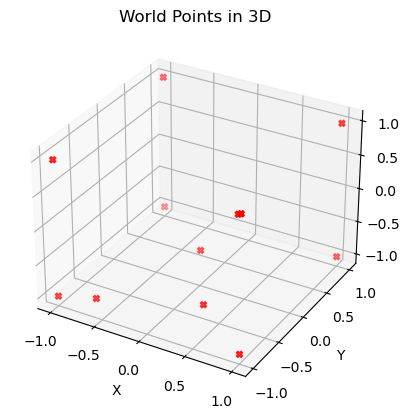

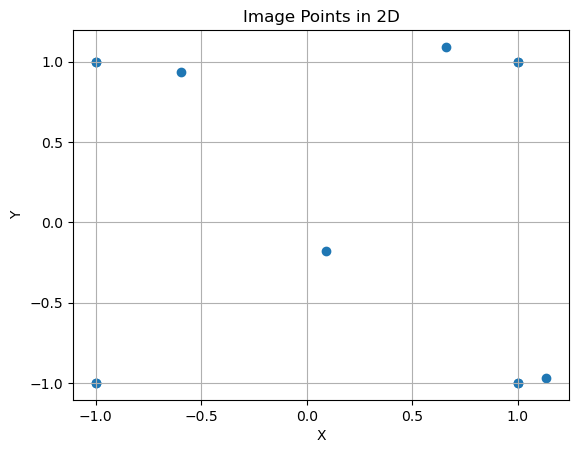

In [14]:
# Perform the camera simulation
x, X = camera_simulation(X_world, fx, fy, cx, cy, s, R, t)

P_est = camera_calibration_dlt(X[:-1].T,x.T)
print("The estimated Calibration Matrix is: \n", P_est)

# Perform the visualization
visualize(x, X)


In [15]:
def matrix_to_vector(A):
    return A.reshape(-1)

def skew_symmetric_matrix(v):
    n = len(v)
    skew_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            skew_matrix[i, j] = -v[j] if i < j else v[j]
    return skew_matrix

def kronecker_product(world_points, image_points):
    return np.kron(world_points, image_points)